## Step 1: Frame sorting

### Overview

The **PL data reduction process** begins with frame sorting — organizing PL frames based on the PSF peak coordinates. 


---

### Process Workflow

The frame sorting procedure involves four key stages:

1. **Timestamp Matching**  
   Match timestamps between the two cameras (The PSF camera usually runs faster than the PL camera.)

2. **PSF Peak Detection**  
   Identify PSF peaks within each frame

3. **Grid Definition**  
   Define a grid to sort the PL frames to

4. **Frame Sorting**  
   Sort PL frames into the defined grid and save them to a file

---


> **Note:** The examples in this notebook use a short dataset for demonstration purposes (~50 frames of PL data). The actual data are trimmed for this example.

### 1. Timestamp matching

In [125]:
import PLred.sort as sort
import matplotlib.pyplot as plt
import numpy as np
import importlib
importlib.reload(sort)

<module 'PLred.sort' from '/home/first/yjkim/PLred/PLred/sort.py'>

The below script generates three files:

1. **_fastcam_matched_frames.npy**  
   The PSF frames whose timestamps were matched to the PL frames
2. **.pkl**  
   Dictionary of matched file/frame indices.
3. **_nstacks.npy**  
   Number of stacked fastcam frames per slowcam frame

number of files found: 1


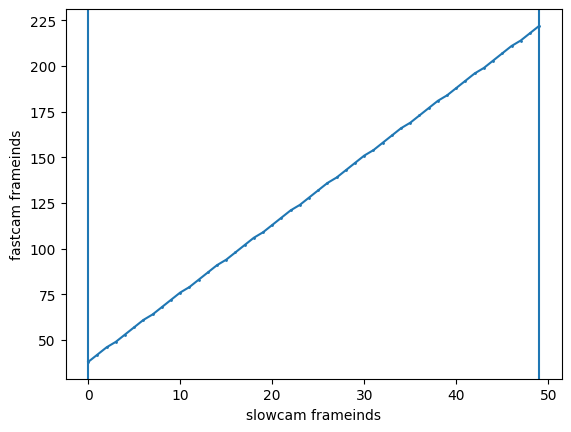

total slowcam images: 49


100%|██████████| 48/48 [00:00<00:00, 134666.62it/s]


timestamp matching file saved to timestamp_matching_output//first_palila_matched.pkl
saving cropped frames, [108:148, 140:180]
reading fastcam file data/fastcam/cropped_palila_15:05:10.002607418.fits


100%|██████████| 48/48 [00:00<00:00, 19302.65it/s]

matched fastcam frames saved to timestamp_matching_output//first_palila_matched_fastcam_matched_frames.npy


In [126]:
configname = 'timestamp_matching_config.ini'
sort.script_match_timestamps(configname)

Now we are ready to work with the simultaneous data!

Use `sort.FrameSorter` class to read these files.

In [127]:
plcam_timestamp_path = 'data/slowcam/'
plcam_spec_path = 'data/slowcam/'
psfcam_frames_name = 'timestamp_matching_output/first_palila_matched_fastcam_matched_frames.npy'
psfcam_timestamp_name = 'timestamp_matching_output/first_palila_matched.pkl'
obs_start = '15:05:17'
obs_end = '15:05:18'

sorter = sort.FrameSorter(plcam_timestamp_path, plcam_spec_path, psfcam_frames_name, psfcam_timestamp_name,
                 obs_start, obs_end, plcam_header = 'cropped_firstpl_')

number of files found: 1
number of files found: 1
Timestamp1 start: 2024-09-17 15:05:17.315891, end 2024-09-17 15:05:18.296350, length 50 
Timestamp2 start: 2024-09-17 15:05:17.315891, end 2024-09-17 15:05:18.256352, length 48 
Filtered 2 out of timestamp1, 0 out of timestamp2


### 2. PSF peak detection

Peak detection is done on all the frames by simply running `compute_psfcam_centroids()`.

Optionally, it is possible to pass the argument `peak = False` to find the center of mass instead of the peak. However I find it not as effective as the peak.

In [128]:
sorter.compute_psfcam_centroids()

Optionally, before binning the data, one may filter out bad frames. One simple way to do this is discarding frames of low Strehl (brightest pixel in the PSF frames).

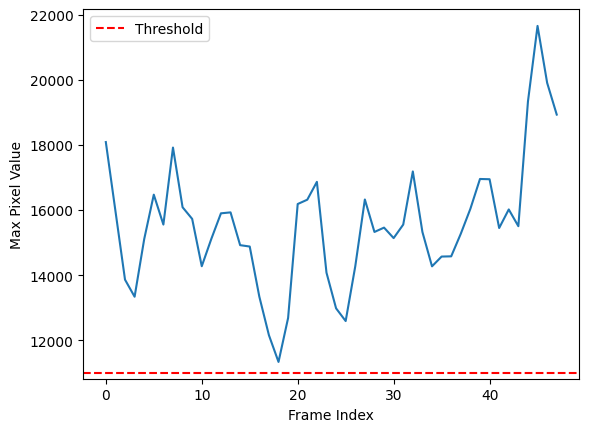

In [129]:
maxvals = np.max(sorter.psfcam_frames, axis=(1, 2))
thres = 11000
idx = maxvals > thres

plt.plot(maxvals)
plt.axhline(thres, color='red', linestyle='--', label='Threshold')
plt.xlabel('Frame Index')
plt.ylabel('Max Pixel Value')
plt.legend()
plt.show()

### 3. Grid definition

Now we sort the frames by the peak positions! `bin_by_centroids()` function does the frame sorting. 

First, we want to find a grid that works for the dataset - adequate number of samplings and field-of-view are needed. To prevent generating a lot of new files set `to_file = False` and `skip_frame_reading = True`. Then we experiment with a few different number of samplings and field-of-view.

/home/first/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/first/miniconda3/envs/sklearn-env/lib/python3.13/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


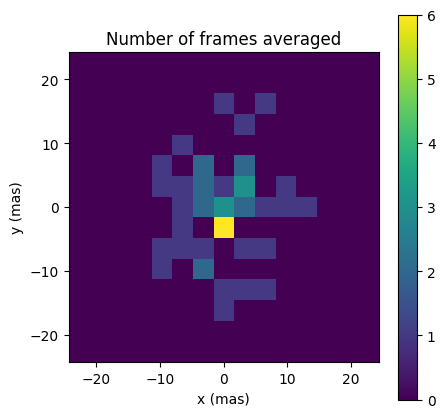

In [130]:
map_n = 15 # Number of samplings in the grid
map_width = 3 # Number of pixels (note, this number * pix2mas is the field-of-view in mas)

psfcam_binned_frames, num_frames, idxs = sorter.bin_by_centroids(map_n, map_width, effective_idx = idx,
                                                                 to_file = False, skip_frame_reading = True)

Definitely we don't need 15 X 15 grid for this small data!

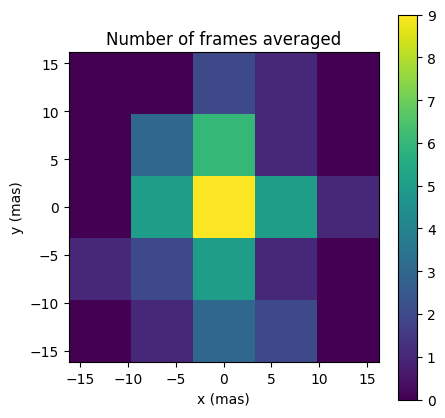

In [131]:
map_n = 5 # Number of samplings in the grid
map_width = 2 # Number of pixels (note, this number * pix2mas is the field-of-view in mas)

psfcam_binned_frames, num_frames, idxs = sorter.bin_by_centroids(map_n, map_width, effective_idx = idx,
                                                                 to_file = False, skip_frame_reading = True)

This looks better. Now we sort the PSF frames and PL frames. This script will generate a file per bin.

Info Saved to remapped/remapped_info.json
creating file remapped/remapped_bin_0_2.h5
creating file remapped/remapped_bin_0_3.h5
creating file remapped/remapped_bin_1_1.h5
creating file remapped/remapped_bin_1_2.h5
creating file remapped/remapped_bin_1_3.h5
creating file remapped/remapped_bin_2_1.h5
creating file remapped/remapped_bin_2_2.h5
creating file remapped/remapped_bin_2_3.h5
creating file remapped/remapped_bin_2_4.h5
creating file remapped/remapped_bin_3_0.h5
creating file remapped/remapped_bin_3_1.h5
creating file remapped/remapped_bin_3_2.h5
creating file remapped/remapped_bin_3_3.h5
creating file remapped/remapped_bin_4_1.h5
creating file remapped/remapped_bin_4_2.h5
creating file remapped/remapped_bin_4_3.h5


0it [00:00, ?it/s]

Start reading file 0
Added frame 0 from file 0 to bin 4,2
Added frame 1 from file 0 to bin 2,4
Added frame 2 from file 0 to bin 2,3
Added frame 3 from file 0 to bin 3,2
Added frame 4 from file 0 to bin 3,1
Added frame 5 from file 0 to bin 3,2
Added frame 6 from file 0 to bin 3,2
Added frame 7 from file 0 to bin 4,1
Added frame 8 from file 0 to bin 2,2
Added frame 9 from file 0 to bin 2,2
Added frame 10 from file 0 to bin 1,2
Added frame 11 from file 0 to bin 3,2
Added frame 12 from file 0 to bin 2,2
Added frame 13 from file 0 to bin 2,2
Added frame 14 from file 0 to bin 2,2
Added frame 15 from file 0 to bin 2,2
Added frame 16 from file 0 to bin 1,2
Added frame 17 from file 0 to bin 0,3
Added frame 18 from file 0 to bin 0,2
Added frame 19 from file 0 to bin 1,2
Added frame 20 from file 0 to bin 2,1
Added frame 21 from file 0 to bin 2,1
Added frame 22 from file 0 to bin 2,1
Added frame 23 from file 0 to bin 1,1
Added frame 24 from file 0 to bin 1,1
Added frame 25 from file 0 to bin 0,2
A

1it [00:00,  4.60it/s]

Added frame 43 from file 0 to bin 3,2
Added frame 44 from file 0 to bin 4,3
Added frame 45 from file 0 to bin 4,3
Added frame 46 from file 0 to bin 4,2
Added frame 47 from file 0 to bin 4,2
Saved plot to remapped/remapped_num_frames.png


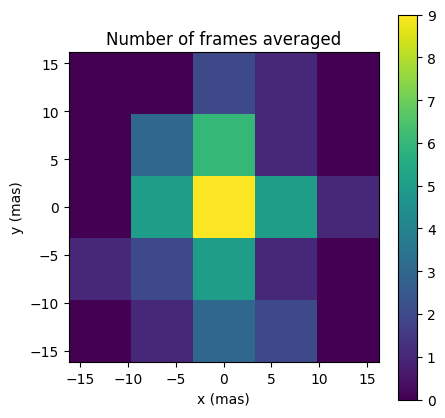

In [132]:
map_n = 5 # Number of samplings in the grid
map_width = 2 # Number of pixels (note, this number * pix2mas is the field-of-view in mas)

psfcam_binned_frames, num_frames, idxs = sorter.bin_by_centroids(map_n, map_width, effective_idx = idx,
                                                                 to_file = True, skip_frame_reading = False,
                                                                 filename = 'remapped/remapped')

Now we are done sorting frames!

Let's take a look at one of the generated h5 files

In [133]:
import h5py

with h5py.File('remapped/remapped_bin_2_2.h5', 'r') as f:
    print('Number of frames: ', f.attrs['num_frames'])
    psfframes = f['psfframes'][:]
    rawframes = f['rawframes'][:]
    

Number of frames:  9


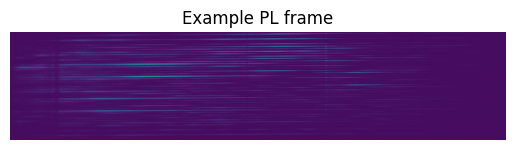

In [134]:
plt.imshow(rawframes[0])
plt.axis('off')
plt.title('Example PL frame')
plt.show()

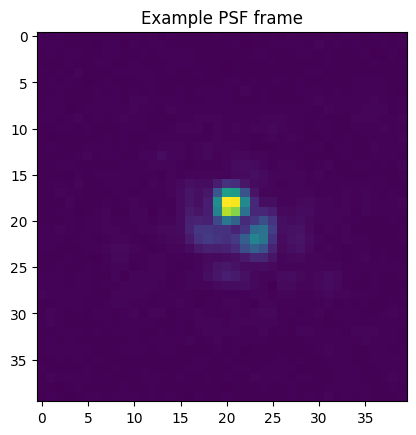

In [135]:
plt.imshow(psfframes[0])
plt.title('Example PSF frame')
plt.show()

The `.info` file stores key parameters for frame sorting.

In [136]:
import json
with open('remapped/remapped_info.json', 'r') as f:
    info = json.load(f)
print(info)

{'xmin': -16.2, 'ymin': -16.2, 'xmax': 16.2, 'ymax': 16.2, 'map_n': 5, 'map_w': 2, 'pix2mas': 16.2}


Before doing actual spectral extraction, we can check what the response maps would look like.

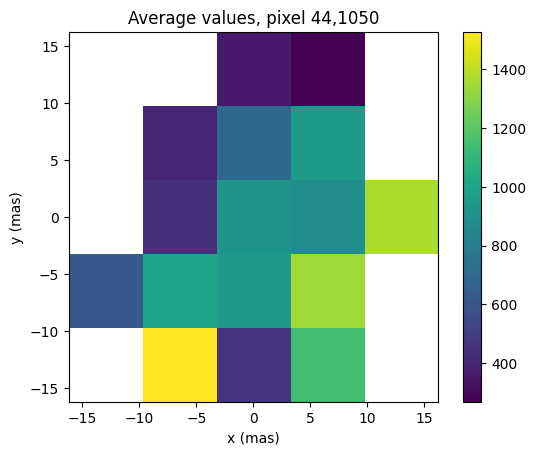

In [137]:
import os

# response map at a specific pixel (port number and wavelength channel)
x,y = 44, 1050  # Pixel coordinates

# Initialize a map to hold the average values
values = np.zeros((5, 5)) + np.nan

# Loop through the remapped files and extract the average values at the pixel (x,y)
for i in range(5):
    for j in range(5):
        if os.path.exists(f'remapped/remapped_bin_{i}_{j}.h5'):
            with h5py.File(f'remapped/remapped_bin_{i}_{j}.h5', 'r') as f:
                values[i,j] = np.average(f['rawframes'][:,x,y])

plt.imshow(values, extent = (info['xmin'], info['xmax'], info['ymin'], info['ymax']),
           origin='upper')
plt.xlabel('x (mas)')
plt.ylabel('y (mas)')
plt.colorbar()
plt.title(f'Average values, pixel {x},{y}')
plt.show()
                

We already see structures in the maps, although only 50 frames are used to construct this map! 
The map is constructed just from the raw pixel values. We need to subtract darks and do spectral extraction. For the FIRST-PL, these steps can be done through the submodule `visPLred`.